In [1]:

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt


import pickle as pkl
from utils import *

import pandas as pd
import seaborn as sns

import cartopy.crs as ccrs

import seaborn as sns

In [2]:
n_modes = 5
lag = 30
modes = 1 + np.arange(n_modes)

regions = ['NorthAmerica', 'SouthAmerica', 'NorthernAfrica', 'SouthernAfrica',
           'Europe','Russia','SouthAsia','EastAsia','Oceania']

scenarios = [585, 370, 245, 126]

dmdcs_hankel = {}
for ssp in scenarios:
    with open(f'./models/DMDc-hankelforcing/tas{ssp}.pkl', 'rb') as f:
        dmdc = pkl.load(f)
        dmdcs_hankel[ssp] = dmdc

xr_train_clim = xr.open_dataset('./data/train_val/outputs_historical.nc').mean(dim='member')
xr_test_clim = xr.open_dataset(f'./data/train_val/outputs_ssp126.nc').mean(dim='member')
times = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').time.values
tas_all = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').tas
lat_data = tas_all.lat
lon_data = tas_all.lon


# a small change to plotting function
plotmap = lambda mode, ax, amax: make_plot(mode, lat_data, lon_data, fig, ax, mode_num=0,
                                           min_val=-amax, max_val=amax, colorbar=True)


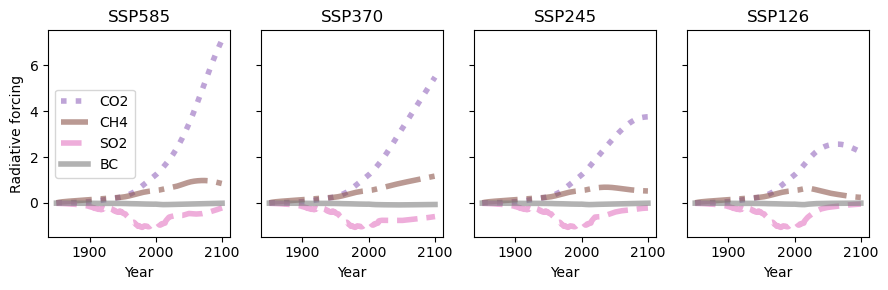

In [3]:
fig, ax = plt.subplots(1,4, figsize=(9,3), sharey=True)
for jj, ssp in enumerate(scenarios):
    forcing_data = np.load(f'./data/forcings/historical+ssp{ssp}_forcing.npy').T


    colors = ['tab:purple', 'tab:brown', 'tab:pink', 'tab:grey']
    linestyles = ['dotted', 'dashdot', 'dashed', 'solid']
    for i, agent in zip([0,1,2,3],['CO2','CH4','SO2','BC']):

        zs = forcing_data[:,i]
        ax[jj].plot(times, zs, lw = 4, label = agent, color = colors[i], linestyle = linestyles[i], alpha = .6)

    
    ax[jj].set_xlabel('Year')
    ax[jj].set_title(f'SSP{ssp}')

ax[0].set_ylabel('Radiative forcing')
ax[0].legend(loc='center left')
plt.tight_layout()
plt.savefig('./plots/radiative_forcing.pdf')

In [4]:

forced_means = {}
forced_contr = {}
for scenario in scenarios:
    xr_train_clim = xr.open_dataset('./data/train_val/outputs_historical.nc').mean(dim='member')
    xr_test_clim = xr.open_dataset(f'./data/train_val/outputs_ssp{scenario}.nc').mean(dim='member')

    tas_all = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').tas.values
    times = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').time
    ntime, nlat, nlong = tas_all.shape
    tas_data = tas_all.reshape(ntime, -1)[lag-1:,:]
    
    forcing_data = np.load(f'./data/forcings/historical+ssp{scenario}_forcing.npy').T
    control_data = TDE_wravel(forcing_data, lag = lag)

    my_dmdc = dmdcs_hankel[ssp]
 
    idx = np.argsort(np.real(my_dmdc.eigs))[::-1][:1]
    sel_modes = my_dmdc.modes[:,idx]
    sel_dynamics = my_dmdc.dynamics[idx,:]
    sel_eigs = my_dmdc.eigs[idx]


    forced_meanies = []

    forcing_contribution = np.real(np.linalg.multi_dot([sel_modes, np.eye(len(sel_eigs)), np.linalg.pinv(sel_modes), tas_data[1:,:].T]))
    forced_contr[scenario] = forcing_contribution
    forced_meanies.append(np.mean(forcing_contribution, axis = 0))
    forcing_contribution = np.real(my_dmdc.B @ control_data[:-1,:].T)
    forced_meanies.append(np.mean(forcing_contribution, axis = 0))
    forced_means[scenario] = forced_meanies


In [5]:
tde_times = TDE_wravel(np.expand_dims(times,axis = 1),30)
tde_times

array([[1850., 1851., 1852., ..., 1877., 1878., 1879.],
       [1851., 1852., 1853., ..., 1878., 1879., 1880.],
       [1852., 1853., 1854., ..., 1879., 1880., 1881.],
       ...,
       [2069., 2070., 2071., ..., 2096., 2097., 2098.],
       [2070., 2071., 2072., ..., 2097., 2098., 2099.],
       [2071., 2072., 2073., ..., 2098., 2099., 2100.]])

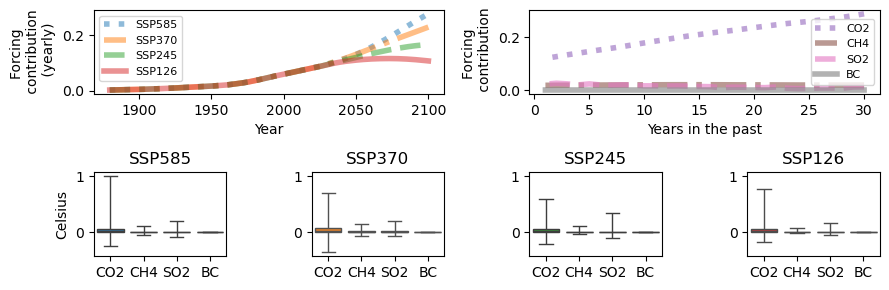

In [6]:
# Create a boxplot
fig = plt.figure(figsize=(9,3))
gs = fig.add_gridspec(2, 4)
linestyles = ['dotted', 'dashdot', 'dashed', 'solid']


ax1 = fig.add_subplot(gs[0,:2])
for scenario, ls in zip([585, 370, 245, 126], linestyles):
    for j in range(1):
        xr_train_clim = xr.open_dataset('./data/train_val/outputs_historical.nc').mean(dim='member')
        xr_test_clim = xr.open_dataset(f'./data/train_val/outputs_ssp{scenario}.nc').mean(dim='member')
        tas_all = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').tas.values       
        ntime, nlat, nlong = tas_all.shape
        tas_data = tas_all.reshape(ntime, -1)  
        ax1.plot(times[lag:], forced_means[scenario][1], label = f'SSP{scenario}', alpha = .5, linestyle = ls, lw = 4) 

ax1.set_xlabel('Year')
ax1.set_ylabel('Forcing \n contribution \n (yearly)')
ax1.legend(fontsize = 8)


ax2 = fig.add_subplot(gs[0,2:])
colors = ['tab:purple', 'tab:brown', 'tab:pink', 'tab:grey']
emissions_agents = ['CO2','CH4','SO2','BC']
for ii, agent in zip([0,1,2,3],emissions_agents):
    zs_all = []
    for ssp, ls in zip([585, 370, 245, 126], linestyles):

        forcing_data = np.load(f'./data/forcings/historical+ssp{ssp}_forcing.npy').T
        control_data = TDE_wravel(forcing_data, lag = lag)[-50:,:] #last 50 years: 2051 to 2100
        zs = []
        idxs = np.arange(ii,(lag)*4,4)[::-1]
        for i in range(lag):
            # take the forcing contribution of agent ii over last 50 years 2051 to 2100 
            z = np.sum(dmdcs_hankel[ssp].B[:,[idxs[i]]] @ control_data[:,[idxs[i]]].T, axis = 1)
            # z is a spatial pattern with 30 time lags
            zs.append(z)
        
        zs = np.vstack(zs)
        # take the real part and spatial mean
        zs = np.real(np.mean(zs, axis = 1))
        # collect these patterns over all scenarios
        zs_all.append(zs)
    # plot the mean over all scenarios
    ax2.plot(np.arange(1,lag+1)[::-1], np.mean(np.vstack(zs_all),axis = 0), lw = 4, linestyle = linestyles[ii], alpha = .6, c = colors[ii], label = agent)
ax2.legend(fontsize=8)
ax2.set_xlabel('Years in the past')
ax2.set_ylabel('Forcing \n contribution')


colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for ii, ssp in enumerate(scenarios):
    forcing_data = np.load(f'./data/forcings/historical+ssp{ssp}_forcing.npy').T
    control_data = TDE_wravel(forcing_data, lag = lag)

    data = {}
    for i, agent in zip([0,1,2,3],['CO2','CH4','SO2','BC']):
        hankel_idx = np.arange(i,lag*4,4)[::-1]

        zs = dmdcs_hankel[ssp].B[:, hankel_idx] @ control_data[:,hankel_idx].T

        data[agent] = np.real(zs.flatten())
    
    if ii == 0:
        ax0 = fig.add_subplot(gs[1,ii])
        ax0.set_ylabel('Celsius')
        ax3s = ax0
    else:
        ax3s = fig.add_subplot(gs[1,ii], sharey=ax0)
    axi = sns.boxplot(data=data, palette = 4*[colors[ii]],
                     ax = ax3s, whis = np.inf)

    ax3s.set_title(f'SSP{ssp}')

# 


plt.tight_layout()
plt.savefig('./plots/forcing_summary.pdf')


In [7]:
for ssp in scenarios:
    forcing_data = np.load(f'./data/forcings/historical+ssp{ssp}_forcing.npy').T
    control_data = TDE_wravel(forcing_data, lag = lag)
    control_data = control_data[-50:,:].T # remove last year
    print(np.std(dmdcs_hankel[ssp].B @ control_data))

0.1977130584788583
0.157589592821149
0.1398795803673087
0.14000782256161848


[2071. 2072. 2073. 2074. 2075. 2076. 2077. 2078. 2079. 2080. 2081. 2082.
 2083. 2084. 2085. 2086. 2087. 2088. 2089. 2090. 2091. 2092. 2093. 2094.
 2095. 2096. 2097. 2098. 2099. 2100.]


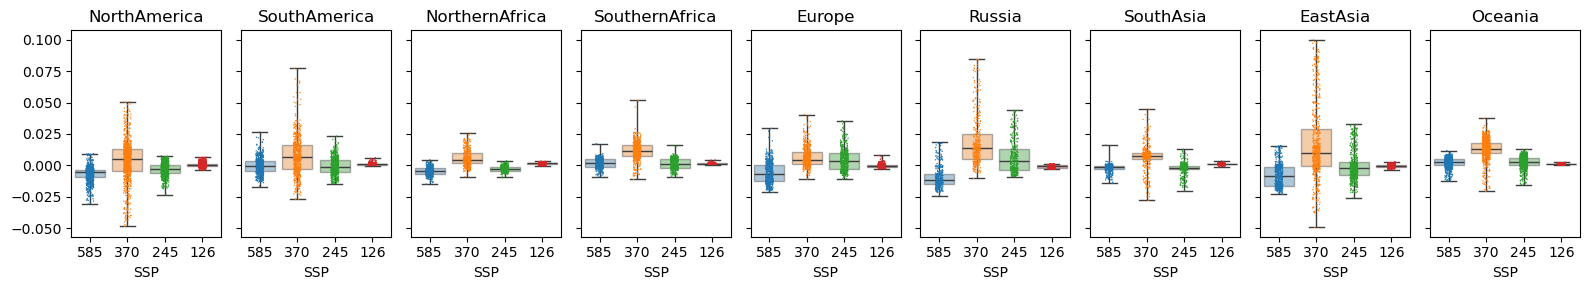

In [8]:
print(tde_times[-1,:])
SO2_idx = np.arange(2,lag*4,4)[::-1]
regions = [ 'NorthAmerica', 'SouthAmerica', 'NorthernAfrica', 'SouthernAfrica',
           'Europe','Russia','SouthAsia','EastAsia','Oceania']
fig, axs = plt.subplots(1,len(regions), figsize = (16,3), sharey = True)
for j, region in enumerate(regions):
    box_data = pd.DataFrame(columns = scenarios)

    colors = ['tab:blue','tab:orange','tab:green','tab:red'] 

    for i, ssp in enumerate(scenarios):
        forcing_data = np.load(f'./data/forcings/historical+ssp{ssp}_forcing.npy').T
        control_data = TDE_wravel(forcing_data, lag = lag)

                

        X0 = np.real(dmdcs_hankel[ssp].B[:, SO2_idx] @ control_data[:,SO2_idx].T)[:,[-1]]

        cropped_data = crop_data(X0, lat_data, lon_data, region)
        box_data[ssp] = cropped_data.values.flatten()

    ax = sns.boxplot(data=box_data, boxprops={'alpha': 0.4}, 
                     order = scenarios, palette = colors[::-1],
                     ax = axs[j], whis = np.inf)
    sns.stripplot(data=box_data, ax=ax, size = 1, palette = colors[::-1])
    ax.set_title(region)
    ax.set_xlabel('SSP')

plt.tight_layout()

plt.savefig('plots/cooling_trend_landmass.pdf')



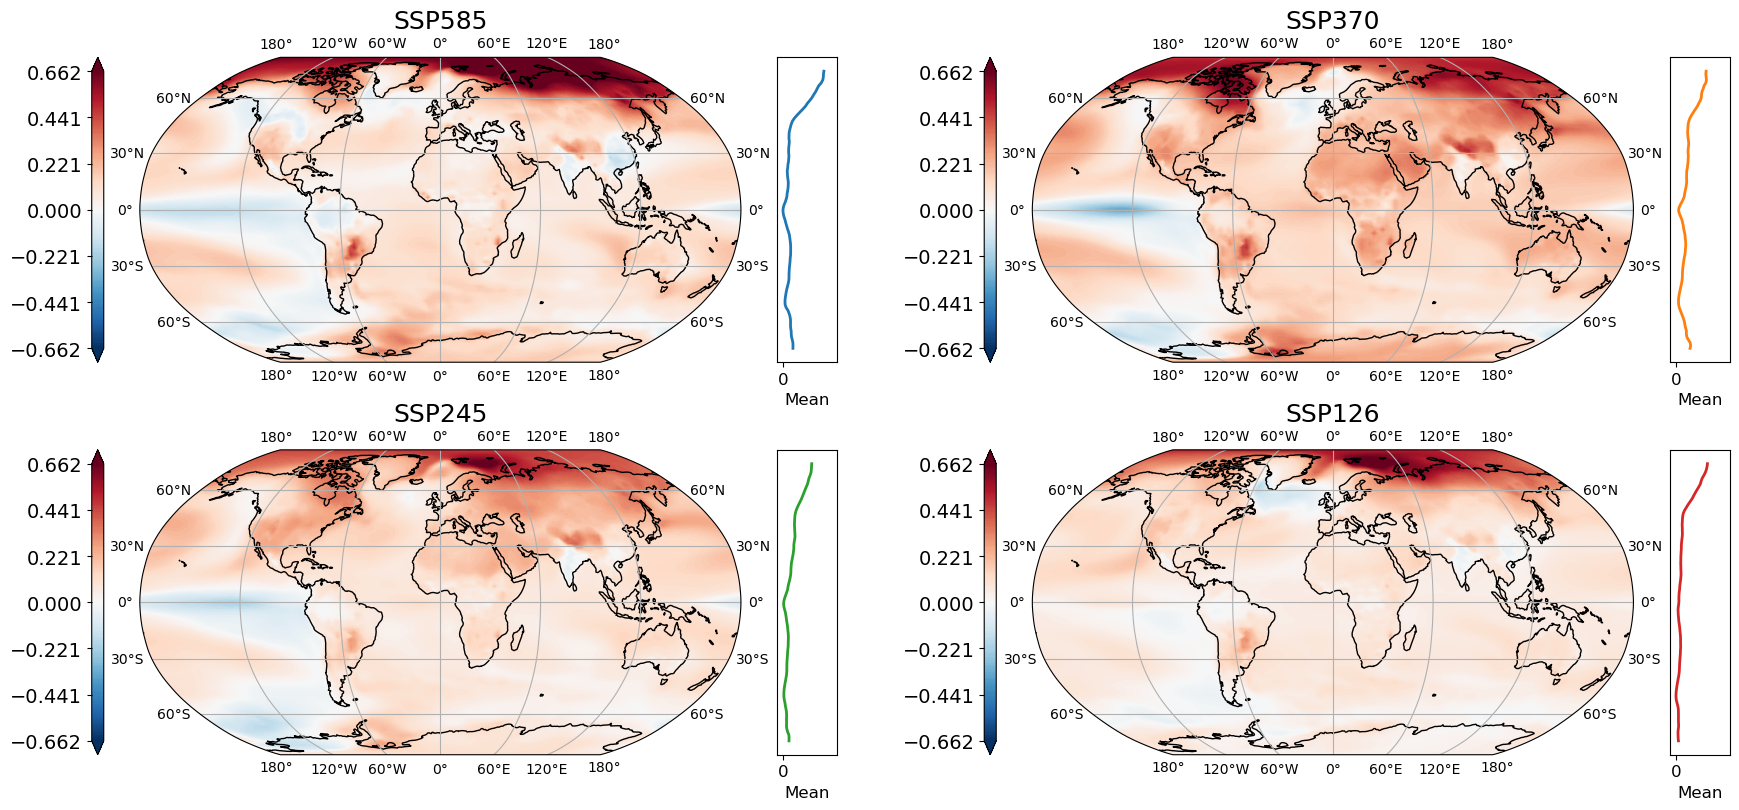

In [9]:
lag = 30
fig, ax = plt.subplots(2, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.Robinson()})
 
caxs = []
for axi in ax.flatten():
    caxs.append(axi.inset_axes((1.06, 0, 0.1, 1)))

ssp = 585

forcing_data = np.load(f'./data/forcings/historical+ssp{ssp}_forcing.npy').T
control_data = TDE_wravel(forcing_data, lag = lag)
control_data = control_data[-50:,:].T # remove last year

amax = np.max([np.real(np.mean(dmdcs_hankel[ssp].B @ control_data, axis = 1)).max(),-np.real(np.mean(dmdcs_hankel[ssp].B @ control_data, axis = 1)).min()])

colors = ['tab:blue','tab:orange','tab:green','tab:red'] 
ax_idx = [(0,0),(0,1),(1,0),(1,1)]
Xalls = {}
for i, ssp in enumerate(scenarios):

    forcing_data = np.load(f'./data/forcings/historical+ssp{ssp}_forcing.npy').T
    control_data = TDE_wravel(forcing_data, lag = lag)
    control_data = control_data[-50:,:].T # remove last year
        
    X_all = np.real(np.mean(dmdcs_hankel[ssp].B @ control_data, axis = 1))
    plotmap(X_all, ax[ax_idx[i]], amax-.2)
    ax[ax_idx[i]].set_title(f"SSP{ssp}",
                    fontdict = {'fontsize':18})

    Xalls[ssp] = X_all

        
    
for j in range(4):
    for i, ssp in enumerate(scenarios):
        if i == j:
            a = 1
        else:
            a = 0
        caxs[j].plot(np.mean(Xalls[ssp].reshape(96, 144), axis = 1), lat_data, color = colors[i], alpha = a, lw = 2)
        caxs[j].set_yticks([])
        caxs[j].set_xlim([-.1,amax])
        caxs[j].set_xticks([0])
        caxs[j].set_xlabel('Mean',fontsize=12)
        caxs[j].tick_params(axis='x',labelsize=12)

plt.tight_layout()

plt.savefig(f'plots/emissions_By_total.pdf', bbox_inches = 'tight')

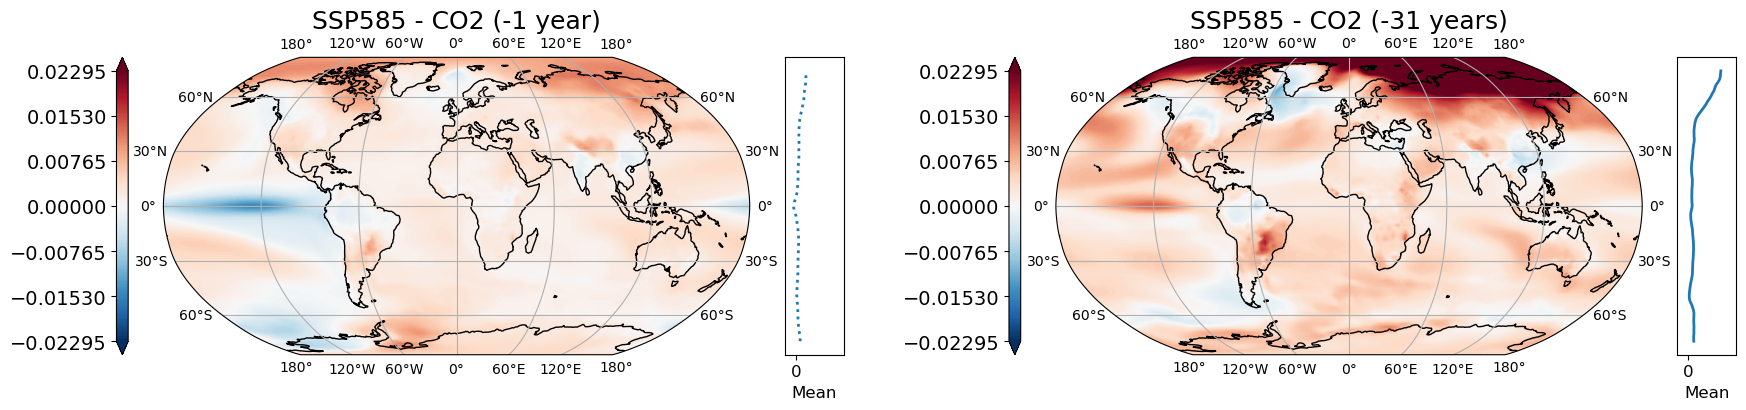

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4), subplot_kw={'projection': ccrs.Robinson()})

caxs = []
for axi in ax.flatten():
    # caxs.append(axi.inset_axes((1.02, 0, 0.1, 1)))
    caxs.append(axi.inset_axes((1.06, 0, 0.1, 1)))

ssp = 585

lag = 30
CO2_idx = np.arange(0,30*4,4)[[0]]
CO2_idx1 = np.arange(0,30*4,4)[[-1]]

forcing_data = np.load(f'./data/forcings/historical+ssp{ssp}_forcing.npy').T
control_data = TDE_wravel(forcing_data, lag = lag)
control_data = control_data[-50:,:].T # remove last year

#CO2
amax = np.max([np.real(np.mean(dmdcs_hankel[ssp].B[:, CO2_idx1]@ control_data[CO2_idx1,:], axis = 1)).max(),-np.real(np.mean(dmdcs_hankel[ssp].B[:, CO2_idx1]@ control_data[CO2_idx1,:], axis = 1)).min()])

X_co2 = np.real(np.mean(dmdcs_hankel[ssp].B[:, CO2_idx]@ control_data[CO2_idx,:], axis = 1))
plotmap(X_co2, ax[0], amax-.02)
ax[0].set_title(f"SSP{ssp} - CO2 (-1 year)",
                   fontdict = {'fontsize':18})

X1_co2 = np.real(np.mean(dmdcs_hankel[ssp].B[:, CO2_idx1]@ control_data[CO2_idx1,:], axis = 1))
plotmap(X1_co2, ax[1], amax-.02)
ax[1].set_title(f"SSP{ssp} - CO2 (-31 years)",
                   fontdict = {'fontsize':18})

linestyles = ['dotted', 'solid']
for i in range(2):
    for j, X0 in enumerate([X_co2, X1_co2]):
        if i == j:
            a = 1
        else:
            a = 0
        caxs[i].plot(np.mean(X0.reshape(96, 144), axis = 1), lat_data, color = 'tab:blue', alpha = a, lw = 2, linestyle = linestyles[j])
        caxs[i].set_yticks([])
        caxs[i].set_xlim([-.01,amax])
        caxs[j].set_xticks([0])
        caxs[j].set_xlabel('Mean',fontsize=12)
        caxs[j].tick_params(axis='x',labelsize=12)


plt.tight_layout()
plt.savefig('plots/c02_By.pdf', bbox_inches = 'tight')


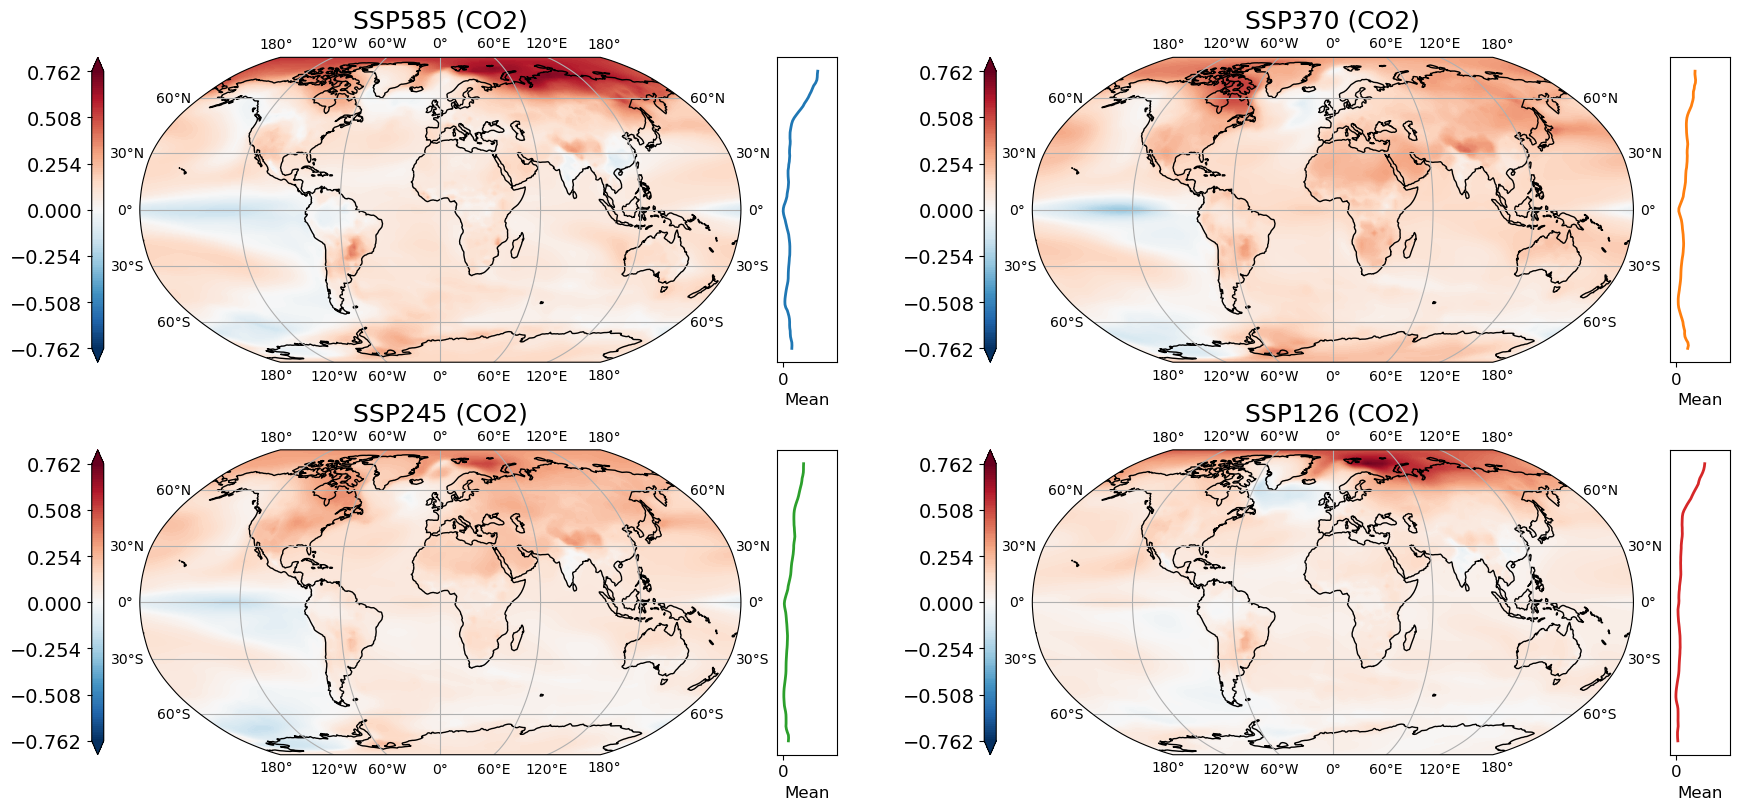

In [11]:
lag = 30
CO2_idx = np.arange(0,lag*4,4)
CH4_idx = np.arange(1,lag*4,4)
SO2_idx = np.arange(2,lag*4,4)
BC_idx = np.arange(3,lag*4,4)
fig, ax = plt.subplots(2, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.Robinson()})
 
caxs = []
for axi in ax.flatten():
    caxs.append(axi.inset_axes((1.06, 0, 0.1, 1)))

ssp = 585

forcing_data = np.load(f'./data/forcings/historical+ssp{ssp}_forcing.npy').T
control_data = TDE_wravel(forcing_data, lag = lag)
control_data = control_data[-50:,:].T # remove last year

amax = np.max([np.real(np.mean(dmdcs_hankel[ssp].B @ control_data, axis = 1)).max(),-np.real(np.mean(dmdcs_hankel[ssp].B @ control_data, axis = 1)).min()])

colors = ['tab:blue','tab:orange','tab:green','tab:red'] 
ax_idx = [(0,0),(0,1),(1,0),(1,1)]
Xalls = {}
for i, ssp in enumerate(scenarios):

    forcing_data = np.load(f'./data/forcings/historical+ssp{ssp}_forcing.npy').T
    control_data = TDE_wravel(forcing_data, lag = lag)
    control_data = control_data[-50:,:].T # remove last year
        
    X_all = np.real(np.mean(dmdcs_hankel[ssp].B[:,CO2_idx] @ control_data[CO2_idx,:], axis = 1))
    plotmap(X_all, ax[ax_idx[i]], amax-.1)
    ax[ax_idx[i]].set_title(f"SSP{ssp} (CO2)",
                    fontdict = {'fontsize':18})

    Xalls[ssp] = X_all

        
    
for j in range(4):
    for i, ssp in enumerate(scenarios):
        if i == j:
            a = 1
        else:
            a = 0
        caxs[j].plot(np.mean(Xalls[ssp].reshape(96, 144), axis = 1), lat_data, color = colors[i], alpha = a, lw = 2)
        caxs[j].set_yticks([])
        caxs[j].set_xlim([-.1,amax])
        caxs[j].set_xticks([0])
        caxs[j].set_xlabel('Mean',fontsize=12)
        caxs[j].tick_params(axis='x',labelsize=12)

plt.tight_layout()

plt.savefig(f'plots/emissions_By_co2.pdf', bbox_inches = 'tight')

In [12]:
TDE_wravel(np.expand_dims(times,axis = 1),30)[-100:-80,:]

array([[1972., 1973., 1974., 1975., 1976., 1977., 1978., 1979., 1980.,
        1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988., 1989.,
        1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998.,
        1999., 2000., 2001.],
       [1973., 1974., 1975., 1976., 1977., 1978., 1979., 1980., 1981.,
        1982., 1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990.,
        1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999.,
        2000., 2001., 2002.],
       [1974., 1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982.,
        1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991.,
        1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
        2001., 2002., 2003.],
       [1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982., 1983.,
        1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991., 1992.,
        1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001.,
        2002., 2003., 2004.],
       [1976., 1977., 1978.,

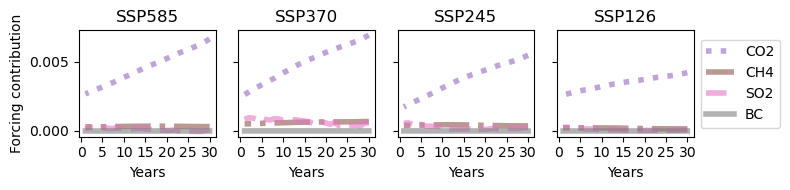

In [13]:
fig, ax = plt.subplots(1,4, figsize = (8,2), sharey='row')
for ii, ssp in enumerate(scenarios):
    colors = ['tab:purple', 'tab:brown', 'tab:pink', 'tab:grey']
    linestyles = ['dotted', 'dashdot', 'dashed', 'solid']

    forcing_data = np.load(f'./data/forcings/historical+ssp{ssp}_forcing.npy').T
    control_data = TDE_wravel(forcing_data, lag = lag)
    control_data = control_data[-50:,:].T #except last year

    for i, agent in zip([0,1,2,3,4],['CO2','CH4','SO2','BC']):
        hankel_idx = np.arange(i,120,4)[::-1]
        ys = []
        for j in range(0, 30):  
            X = np.real(dmdcs_hankel[ssp].B[:, [hankel_idx[j]]] @ control_data[[hankel_idx[j]],:])
            ys.append(X.mean())
        ax[ii].plot(np.arange(1,31)[::-1], ys, lw = 4, label = agent, color = colors[i], linestyle = linestyles[i], alpha = .6)
    ax[ii].set_xticks([0,5,10,15,20,25,30])
    ax[ii].set_title(f'SSP{ssp}')
    ax[ii].set_xlabel('Years')

ax[0].set_ylabel('Forcing contribution')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/forcing_by_agent_ssp_By.pdf')